In [1]:
!pip install transformers==3.0.1 
import numpy as np
import pandas as pd
import torch, math
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import BertTokenizerFast
# specify GPU
device = torch.device("cuda")
from transformers import *
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
config = BertConfig.from_pretrained('bert-large-uncased', num_labels=2)

In [2]:
class BertTwoSentences(BertPreTrainedModel):
    def __init__(self, config, num_labels):
        super(BertTwoSentences, self).__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.pre_linear = nn.Linear(config.hidden_size, 300)
        self.activation = nn.SELU()
        self.reduce_fuse_linear = nn.Linear(600, 300)
        self.cos = nn.CosineSimilarity()
        self.rank_margin = nn.MarginRankingLoss(margin=0.4)
        self.init_weights()
    def forward(self, sentence1, sentence2, labels=None):
        _, sentence1 = self.bert(sentence1)
        sentence1 = self.activation(sentence1)
        sentence1 = self.pre_linear(sentence1)
        ori = sentence2
        _, sentence2 = self.bert(sentence2)
        sentence2 = self.activation(sentence2)
        sentence2 = self.pre_linear(sentence2)
        sent_concat = torch.cat((sentence1 + sentence2, sentence1 * sentence2), dim=1)
        sent_concat = self.reduce_fuse_linear(sent_concat)
        cos_sim1 = self.cos(sent_concat, sentence1)
        cos_sim2 = self.cos(sent_concat, sentence2)
        outputs = (cos_sim1, cos_sim2), None, None
        if labels is not None:
            labels[labels==0] = -1
            loss_rank = self.rank_margin(cos_sim1, cos_sim2, labels)
            outputs = (loss_rank,) + outputs
        return outputs

In [3]:
import torch.nn as nn
model = BertTwoSentences.from_pretrained('bert-large-uncased', config=config, num_labels=2)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertTwoSentences: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertTwoSentences from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertTwoSentences from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertTwoSentences were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['pr

In [4]:
model = model.to(device)

In [5]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8 )

In [6]:
from google.colab import files

uploaded = files.upload() #upload all 6 datasets here

Saving subtaskA__dev_gold_answers.csv to subtaskA__dev_gold_answers (1).csv
Saving subtaskA_answers_all.csv to subtaskA_answers_all (1).csv
Saving subtaskA_data_all.csv to subtaskA_data_all (1).csv
Saving subtaskA_dev_data.csv to subtaskA_dev_data (1).csv
Saving subtaskA_gold_answers.csv to subtaskA_gold_answers (1).csv
Saving subtaskA_test_data.csv to subtaskA_test_data (1).csv


In [7]:
train_text = pd.read_csv("subtaskA_data_all.csv")
train_lab = pd.read_csv("subtaskA_answers_all.csv",header=None)
train_lab = train_lab.drop([0], axis=1)
train_labels = train_lab.rename(columns={1: 'Invalid'})
test_text = pd.read_csv("subtaskA_test_data.csv")
test_lab = pd.read_csv("subtaskA_gold_answers.csv",header=None)
test_lab = test_lab.drop([0], axis=1)
test_labels = test_lab.rename(columns={1: 'Invalid'})
val_text = pd.read_csv("subtaskA_dev_data.csv")
val_lab = pd.read_csv("subtaskA__dev_gold_answers.csv",header=None)
val_lab = val_lab.drop([0], axis=1)
val_labels = val_lab.rename(columns={1: 'Invalid'})

In [8]:
train_sen0, train_sen1 = train_text['sent0'], train_text['sent1']
val_sen0, val_sen1 = val_text['sent0'], val_text['sent1']
test_sen0, test_sen1 = test_text['sent0'], test_text['sent1']
train_labels, val_labels, test_labels = train_labels['Invalid'], val_labels['Invalid'], test_labels['Invalid']

In [9]:
import logging
logging.basicConfig(level=logging.ERROR)
total_tk_size = 20
tokens_train0 = tokenizer.batch_encode_plus(train_sen0.tolist(), max_length = total_tk_size, pad_to_max_length=True, 
                                            truncation=True, return_token_type_ids=False)
tokens_train1 = tokenizer.batch_encode_plus(train_sen1.tolist(), max_length = total_tk_size, pad_to_max_length=True,
                                            truncation=True, return_token_type_ids=False)
tokens_val0 = tokenizer.batch_encode_plus(val_sen0.tolist(), max_length = total_tk_size, pad_to_max_length=True, 
                                          truncation=True, return_token_type_ids=False)
tokens_val1 = tokenizer.batch_encode_plus(val_sen1.tolist(), max_length = total_tk_size, pad_to_max_length=True,
                                          truncation=True, return_token_type_ids=False)
tokens_test0 = tokenizer.batch_encode_plus(test_sen0.tolist(), max_length = total_tk_size, pad_to_max_length=True,
                                           truncation=True, return_token_type_ids=False)
tokens_test1 = tokenizer.batch_encode_plus(test_sen1.tolist(), max_length = total_tk_size, pad_to_max_length=True, 
                                           truncation=True, return_token_type_ids=False)

In [10]:
# for train set 0 
train_seq0 = torch.tensor(tokens_train0['input_ids'])
train_mask0 = torch.tensor(tokens_train0['attention_mask'])
train_y = torch.tensor(train_labels.tolist())
# for train set 1
train_seq1, train_mask1 = torch.tensor(tokens_train1['input_ids']), torch.tensor(tokens_train1['attention_mask'])
# for validation set 0
val_seq0 = torch.tensor(tokens_val0['input_ids'])
val_mask0 = torch.tensor(tokens_val0['attention_mask'])
val_y = torch.tensor(val_labels.tolist())
# for validation set 1
val_seq1, val_mask1 = torch.tensor(tokens_val1['input_ids']), torch.tensor(tokens_val1['attention_mask'])
# for test set 0
test_seq0 = torch.tensor(tokens_test0['input_ids'])
test_mask0 = torch.tensor(tokens_test0['attention_mask'])
test_y = torch.tensor(test_labels.tolist())
# for test set 1
test_seq1, test_mask1 = torch.tensor(tokens_test1['input_ids']), torch.tensor(tokens_test1['attention_mask'])

In [11]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#define a batch size
batch_size = 16
# wrap tensors
train_data0, train_data1 = TensorDataset(train_seq0, train_mask0, train_y), TensorDataset(train_seq1, train_mask1, train_y)
# dataLoader for train set
train_dataloader0 = DataLoader(train_data0, sampler=None, batch_size=batch_size)
train_dataloader1 = DataLoader(train_data1, sampler=None, batch_size=batch_size)
# wrap tensors
val_data0, val_data1 = TensorDataset(val_seq0, val_mask0, val_y), TensorDataset(val_seq1, val_mask1, val_y)
# sampler for sampling the data during training
val_sampler0, val_sampler1 = SequentialSampler(val_data0), SequentialSampler(val_data1)
# dataLoader for validation set
val_dataloader0 = DataLoader(val_data0, sampler = val_sampler0, batch_size=batch_size)
val_dataloader1 = DataLoader(val_data1, sampler = val_sampler1, batch_size=batch_size)

In [12]:
#convert class weights to tensor
from sklearn.utils.class_weight import compute_class_weight
#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)
print(class_wts)
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)
epochs = 10

[1.00421771 0.99581757]


In [13]:
# function to train the model
def train():
  model.train()
  total_loss, total_accuracy = 0, 0
  # iterate over batches
  for step, batch in enumerate(train_dataloader0):
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader0)))
    for idx, bay in enumerate(train_dataloader1):
      if idx == step :batch11 = bay
    # push the batch to gpu
    batch0 = [r.to(device) for r in batch]
    batch1 = [r.to(device) for r in batch11]
    sent_id0, mask0, labelss = batch0
    sent_id1, mask1, labels = batch1
    # clear previously calculated gradients 
    model.zero_grad()        
    # get model predictions for the current batch
    loss, preds, _, _ = model(sent_id0, sent_id1, labels)
    x,y = preds
    # add on to the total loss
    total_loss = total_loss + loss.item()
    # backward pass to calculate the gradients
    loss.backward()
    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # update parameters
    optimizer.step()
    # model predictions are stored on GPU. So, push it to CPU
  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader0)
  #returns the loss 
  return avg_loss

In [14]:
# function for evaluating the model
def evaluate():
  print("\nEvaluating...")
  # deactivate dropout layers
  model.eval()
  total_loss, total_accuracy = 0, 0
  # iterate over batches
  x1 = 0
  for step,batch in enumerate(val_dataloader0):
    for idx, bay in enumerate(train_dataloader1):
      if idx == step :batch11 = bay
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader0)))
    batch0 = [r.to(device) for r in batch]
    batch1 = [r.to(device) for r in batch11]
    sent_id0, mask0, labelss = batch0
    sent_id1, mask1, labels = batch1
    # deactivate autograd
    with torch.no_grad():
      if len(sent_id0) == x1:
        loss,preds,_,_ = model(sent_id0, sent_id1, labelss)
        x,y = preds
        # compute the loss between actual and predicted values
        total_loss = total_loss + loss.item()
        x1 = len(sent_id0)
  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader0) 
  return avg_loss

In [15]:
# set initial loss to infinite
best_valid_loss = float('inf')
# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]
#for each epoch
for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    #train model
    train_loss = train()
    #evaluate model
    valid_loss = evaluate()
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    625.
  Batch   100  of    625.
  Batch   150  of    625.
  Batch   200  of    625.
  Batch   250  of    625.
  Batch   300  of    625.
  Batch   350  of    625.
  Batch   400  of    625.
  Batch   450  of    625.
  Batch   500  of    625.
  Batch   550  of    625.
  Batch   600  of    625.

Evaluating...
  Batch    50  of     63.

Training Loss: 0.202
Validation Loss: 0.000

 Epoch 2 / 10
  Batch    50  of    625.
  Batch   100  of    625.
  Batch   150  of    625.
  Batch   200  of    625.
  Batch   250  of    625.
  Batch   300  of    625.
  Batch   350  of    625.
  Batch   400  of    625.
  Batch   450  of    625.
  Batch   500  of    625.
  Batch   550  of    625.
  Batch   600  of    625.

Evaluating...
  Batch    50  of     63.

Training Loss: 0.073
Validation Loss: 0.000

 Epoch 3 / 10
  Batch    50  of    625.
  Batch   100  of    625.
  Batch   150  of    625.
  Batch   200  of    625.
  Batch   250  of    625.
  Batch   300  of    625.
  B

In [16]:
#load weights of best model
model_name = 'model.pt'
model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [17]:
with torch.no_grad():
  preds,_,_ = model(test_seq0.to(device), test_seq1.to(device))
  x,y = preds
A = x.detach().cpu().numpy() - y.detach().cpu().numpy()
z  = (A > 0).astype(int)
pd.crosstab(test_y, z)

col_0,0,1
row_0,,
0,450,58
1,62,430


In [18]:
a=0
for i in range(len(test_y)):
  if test_y[i] == z[i]:a+=1
print('Total Accuracy on Test Set:', float(a/len(test_y)))

Total Accuracy on Test Set: 0.88


In [23]:
def check(l1,l2):
  t1, t2 = tokenizer.tokenize(l1), tokenizer.tokenize(l2)
  t11, t21 = torch.tensor([tokenizer.convert_tokens_to_ids(t1)]), torch.tensor([tokenizer.convert_tokens_to_ids(t2)])
  preds,_,_ = model(t11.to(device), t21.to(device))
  x,y = preds
  A = x.detach().cpu().numpy() - y.detach().cpu().numpy()
  z  = (A > 0).astype(int)
  return z[0]
a = "whales are huge"
b = "all whales are small"
print('returns the wrong answer:', check(a,b))

returns the wrong answer: 1


In [20]:
test_labi = pd.read_csv("subtaskA_gold_answers.csv",header=None)
test_labi = test_labi.drop([1], axis=1)
test_labi['valid'] = z
pd.DataFrame(test_labi).to_csv("subtaskA_answers.csv", header=None, index = False)

In [24]:
import matplotlib.pyplot as plt

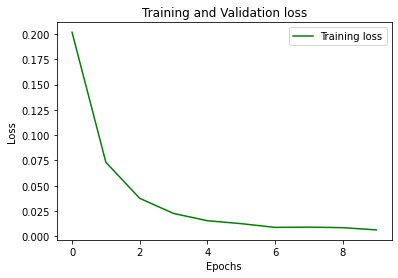

In [36]:
epoochs = range(0,10)
plt.plot(epoochs, train_losses, 'g', label='Training loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()